VGG model as proposed here: https://arxiv.org/pdf/1612.02903v1.pdf


Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git lfs install
!git clone https://github.com/WiktorPieklik/Facial-Expression-Recognition.git
!cd /content/Facial-Expression-Recognition && git checkout custom-net

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'Facial-Expression-Recognition'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 95 (delta 38), reused 83 (delta 28), pack-reused 0
Unpacking objects: 100% (95/95), done.
Branch 'custom-net' set up to track remote branch 'custom-net' from 'origin'.
Switched to a new branch 'custom-net'


In [3]:
!python /content/Facial-Expression-Recognition/install.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 121 kB 6.6 MB/s 
     |████████████████████████████████| 1.6 MB 41.6 MB/s 
     |████████████████████████████████| 83 kB 62.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 6.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.4 MB 1.1 MB/s 
  Attempting uninsta

In [4]:
!cd /content/Facial-Expression-Recognition && python /content/Facial-Expression-Recognition/setup_dataset.py

Decrypting dataset
Reading csv file, this may take a while...
Creating images from csv |                                        | ▁▃▅ 0/35887 [0%] in 0s (0.0/s, eta: -)              
Creating images from csv |                                        | ▂▄▆ 14/35887 [0%] in 0s (124.4/s, eta: 4:48)        
Creating images from csv |                                        | ▃▅▇ 24/35887 [0%] in 0s (151.6/s, eta: 4:23)        
Creating images from csv |                                        | ▄▆█ 31/35887 [0%] in 0s (153.0/s, eta: 4:08)        
Creating images from csv |                                        | ▅▇▇ 39/35887 [0%] in 0s (157.8/s, eta: 3:58)        
Creating images from csv |                                        | ▆█▆ 44/35887 [0%] in 0s (147.4/s, eta: 4:00)        
Creating images from csv |                                        | ▇▇▅ 48/35887 [0%] in 0s (136.5/s, eta: 4:12)        
Creating images from csv |                                        | █▆▄ 51/35887 [0%] in 0s

In [ ]:
# !cp -r "/content/drive/My Drive/TAI/II/Neural-networks/data/" "/content/sample_data/fer"

In [5]:
import os
import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import imgaug.augmenters as iaa

import tensorflow as tf

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Debbuging options

In [ ]:
# uncomment to log device placement of each operation
# tf.debugging.set_log_device_placement(True)

Check GPU

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

Num GPUs Available:  1


## Parameters

In [7]:
IMG_SIZE=(48,48)
INPUT_SHAPE=IMG_SIZE + (1,)

# Choose resize method. The options are:
# area, bicubic, bilinear, gaussian, lanczos3, lanczos5, mitchellcubic, nearest
INTERPOLATION = "bilinear"

BATCH_SIZE=128
MAX_EPOCHS = 300
NUM_CLASSES=7
CLASS_WEIGHTS= {0: 1, 1: 1}
CLASS_NAMES=[]


SEED=1234

Paths

In [103]:
# # choose data directory
TRAIN_DATA_PATH=Path('/content/Facial-Expression-Recognition/raw/images/Training')
VAL_DATA_PATH=Path('/content/Facial-Expression-Recognition/raw/images/PublicTest')
TEST_DATA_PATH=Path('/content/Facial-Expression-Recognition/raw/images/PrivateTest')
# choose logs directory
LOG_DIR = Path('/content/drive/My Drive/TAI/II/Neural-networks/notebooks/logs')

In [104]:
# name your experiment
EXPERIMENT = "Facial-Expression-Recognition-with-VGG"

In [105]:
OUTPUT_DIR = LOG_DIR / EXPERIMENT / 'trial_{:02}'
counter=1
while os.path.exists(str(OUTPUT_DIR).format(counter)):
    counter += 1
OUTPUT_DIR = Path(str(OUTPUT_DIR).format(counter))
os.makedirs(OUTPUT_DIR, exist_ok = True)

In [106]:
summary_filepath = OUTPUT_DIR / 'model.txt'
best_model_filepath = OUTPUT_DIR / f'model.h5'
csv_logger_filepath = OUTPUT_DIR / f'training.log'
history_filepath = OUTPUT_DIR / f'training_history.png'
report_filepath = OUTPUT_DIR / 'report.txt'
confusion_matrix_norm_filepath = OUTPUT_DIR / f'confusion_matrix_norm.png'
confusion_matrix_filepath = OUTPUT_DIR / f'confusion_matrix.png'

## DATA INPUT PIPELINE

Load datasets

In [107]:
train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DATA_PATH,
        color_mode='grayscale',
        label_mode='categorical',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
        VAL_DATA_PATH,
        color_mode='grayscale',
        label_mode='categorical',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False)

test_ds = tf.keras.utils.image_dataset_from_directory(
        TEST_DATA_PATH,
        color_mode='grayscale',
        label_mode='categorical',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False)

class_names = train_ds.class_names

Found 28709 files belonging to 7 classes.
Found 3589 files belonging to 7 classes.
Found 3589 files belonging to 7 classes.


In [108]:
# labels = [np.argmax(y) for x, y in train_ds]
# neg, pos = np.bincount(labels)
# total = neg + pos

# # Scaling by total/2 helps keep the loss to a similar magnitude.
# # The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)


# CLASS_WEIGHTS = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

Show images

In [109]:
# for _ in range(5):
#     img, label = train_ds.take(1)
#     print(img.shape)   #  (1,256,256,3)
#     plt.imshow(img[0][:,:,0], cmap="gray")
#     plt.show()

##### Build model

In [110]:
# import necessary layers

from tensorflow.keras.layers import Input, Conv2D, Dropout
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Rescaling
from tensorflow.keras import Model

input = Input(shape =INPUT_SHAPE)
rescale = Rescaling(1./127.5, offset=-1)

rescaled = rescale(input)

# 1st Conv Block

x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(rescaled)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
x = Dropout(0.2)(x)

# 2nd Conv Block

x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
x = Dropout(0.2)(x)

# 3rd Conv block  
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x) 
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x) 
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
x = Dropout(0.2)(x)

# 4th Conv block

x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
x = Dropout(0.2)(x)

# Fully connected layers  
x = Flatten()(x) 
x = Dense(units = 1024, activation ='relu')(x) 
output = Dense(units = 7, activation ='softmax')(x)
# creating the model

model = Model (inputs=input, outputs =output)
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 48, 48, 1)         0         
                                                                 
 conv2d_120 (Conv2D)         (None, 48, 48, 64)        640       
                                                                 
 conv2d_121 (Conv2D)         (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 24, 24, 64)        0         
                                                          

Save model summary

In [111]:
with open(summary_filepath, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

Compile model

In [112]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              metrics=['accuracy'])

Pre-evaluate model

In [113]:
model.evaluate(test_ds)

29/29 [==============================] - 2s 41ms/step - loss: 1.9463 - accuracy: 0.1619


[1.9462535381317139, 0.16188353300094604]

Callbacks

In [114]:
save_checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath=best_model_filepath)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1)
csv_logger = tf.keras.callbacks.CSVLogger(filename=csv_logger_filepath)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=OUTPUT_DIR)


def schedule(epoch) -> float:
    if epoch >= 5:
        return 0.00005
    return 0.0005
# reduce_lr = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=0)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)


##### Training

In [115]:
history = model.fit(
        train_ds,
        epochs=MAX_EPOCHS,
        validation_data=val_ds,
        callbacks=[save_checkpoint, csv_logger, reduce_lr, early_stop],
        # class_weight=CLASS_WEIGHTS,
        workers=10,
        # use_multiprocessing=True
    )

Epoch 1/300
225/225 [==============================] - 19s 80ms/step - loss: 1.7996 - accuracy: 0.2546 - val_loss: 1.7559 - val_accuracy: 0.2912 - lr: 0.0100
Epoch 2/300
225/225 [==============================] - 26s 114ms/step - loss: 1.7114 - accuracy: 0.3076 - val_loss: 1.6543 - val_accuracy: 0.3589 - lr: 0.0100
Epoch 3/300
225/225 [==============================] - 22s 97ms/step - loss: 1.5933 - accuracy: 0.3755 - val_loss: 1.5227 - val_accuracy: 0.4074 - lr: 0.0100
Epoch 4/300
225/225 [==============================] - 26s 115ms/step - loss: 1.4971 - accuracy: 0.4198 - val_loss: 1.4466 - val_accuracy: 0.4433 - lr: 0.0100
Epoch 5/300
225/225 [==============================] - 21s 92ms/step - loss: 1.4273 - accuracy: 0.4516 - val_loss: 1.4029 - val_accuracy: 0.4681 - lr: 0.0100
Epoch 6/300
225/225 [==============================] - 20s 87ms/step - loss: 1.3480 - accuracy: 0.4842 - val_loss: 1.3159 - val_accuracy: 0.4985 - lr: 0.0100
Epoch 7/300
225/225 [=============================

Evaluate model

In [116]:
# uncomment to load best model
# model=tf.keras.models.load_model(best_model_filepath)

model.evaluate(test_ds)

29/29 [==============================] - 1s 41ms/step - loss: 2.5244 - accuracy: 0.6255


[2.5244016647338867, 0.6255224347114563]

### VISUALIZATION

Loss and accuracy history

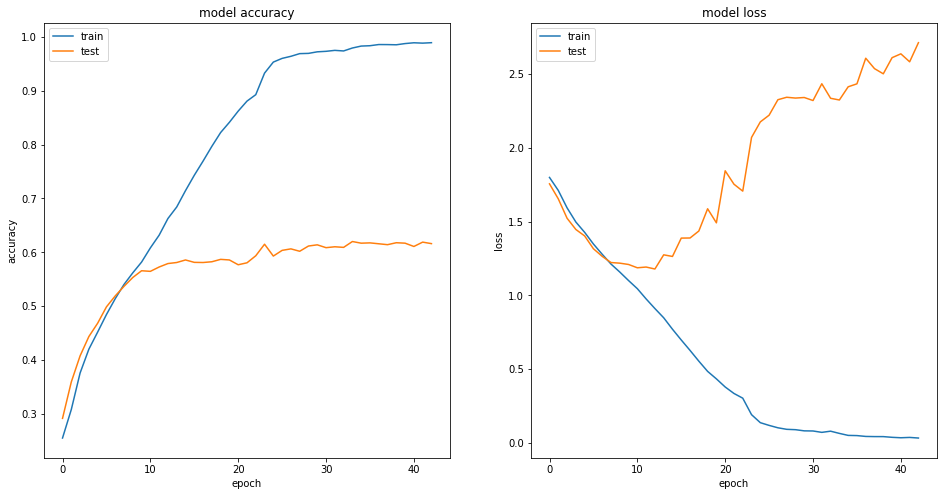

In [117]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.savefig(history_filepath, facecolor='white', bbox_inches='tight')
plt.show()

Trues and predictions

29/29 [==============================] - 1s 45ms/step


<Figure size 432x288 with 0 Axes>

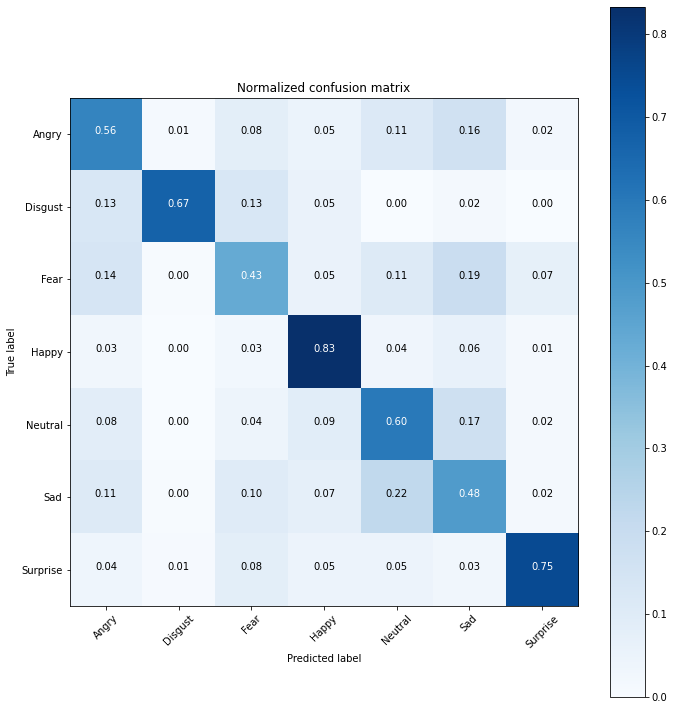

<Figure size 432x288 with 0 Axes>

In [118]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict(test_ds)
preds = [np.argmax(probas) for probas in predictions]
trues = np.concatenate([y for x, y in test_ds], axis=0)
trues = [np.argmax(t) for t in trues]
class_names = test_ds.class_names

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(trues, preds)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()
plt.savefig(confusion_matrix_norm_filepath, facecolor='white', bbox_inches='tight')

Classification report

In [119]:
cr=classification_report(trues,preds,target_names=class_names)
cm = np.array2string(confusion_matrix(trues, preds))
with open(report_filepath, 'w') as f:
    f.write(f'Title\n\nClassification Report\n\n{cr}\n\nConfusion Matrix\n\n{cm}\n')

print(cr)

              precision    recall  f1-score   support

       Angry       0.54      0.56      0.55       491
     Disgust       0.70      0.67      0.69        55
        Fear       0.55      0.43      0.48       528
       Happy       0.81      0.83      0.82       879
     Neutral       0.56      0.60      0.58       626
         Sad       0.45      0.48      0.46       594
    Surprise       0.80      0.75      0.77       416

    accuracy                           0.63      3589
   macro avg       0.63      0.62      0.62      3589
weighted avg       0.63      0.63      0.62      3589



Confusion matrix

<Figure size 720x720 with 0 Axes>

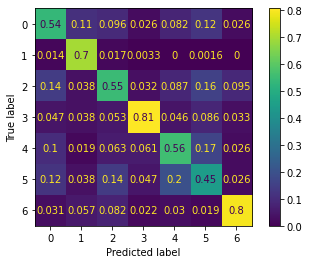

In [120]:
cm=confusion_matrix(trues, preds, normalize='pred')
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.savefig(confusion_matrix_filepath, facecolor='white', bbox_inches='tight')